In [1]:
import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

if code_dir_name not in str(Path.cwd()).split('/')[-1]:
    for _ in range(5):

        parent_path = str(Path.cwd().parents[_]).split('/')[-1]

        if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

            code_dir = str(Path.cwd().parents[_])

            if code_dir is not None:
                break
else:
    code_dir = str(Path.cwd())
sys.path.append(code_dir)

# %load_ext autoreload
# %autoreload 2


In [2]:
from setup_module.imports import *  # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from setup_module.estimators_get_pipe import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from setup_module.plot_metric_fork import functions as plot_metric_functions # type:ignore # isort:skip # fmt:skip # noqa # nopep8


Using MPS


0it [00:00, ?it/s]

Using MPS


<Figure size 640x480 with 0 Axes>

### Set variables

In [3]:
# Variables
method = 'Transformers'
with open(f'{data_dir}{method}_results_save_path.txt', 'r') as f:
    results_save_path = f.read().strip('\n')
with open(f'{data_dir}{method}_done_xy_save_path.txt', 'r') as f:
    done_xy_save_path = f.read().strip('\n')

t = time.time()
n_jobs = -1
n_splits = 10
n_repeats = 3
random_state = 42
refit = True
class_weight = 'balanced'
cv = RepeatedStratifiedKFold(
    n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
)
scoring = 'recall'
scores = [
    'recall', 'accuracy', 'f1', 'roc_auc',
    'explained_variance', 'matthews_corrcoef'
]
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
}
analysis_columns = ['Warmth', 'Competence']
text_col = 'Job Description spacy_sentencized'
metrics_dict = {
    'Mean Cross Validation Train Score': np.nan,
    f'Mean Cross Validation Train - {scoring.title()}': np.nan,
    f'Mean Explained Train Variance - {scoring.title()}': np.nan,
    'Mean Cross Validation Test Score': np.nan,
    f'Mean Cross Validation Test - {scoring.title()}': np.nan,
    f'Mean Explained Test Variance - {scoring.title()}': np.nan,
    'Explained Variance': np.nan,
    'Accuracy': np.nan,
    'Balanced Accuracy': np.nan,
    'Precision': np.nan,
    'Recall': np.nan,
    'F1-score': np.nan,
    'Matthews Correlation Coefficient': np.nan,
    'Brier Score': np.nan,
    'Fowlkes–Mallows Index': np.nan,
    'R2 Score': np.nan,
    'ROC': np.nan,
    'AUC': np.nan,
    f'{scoring.title()} Best Threshold': np.nan,
    f'{scoring.title()} Best Score': np.nan,
    'Log Loss/Cross Entropy': np.nan,
    'Cohen’s Kappa': np.nan,
    'Geometric Mean': np.nan,
    'Classification Report': np.nan,
    'Imbalanced Classification Report': np.nan,
    'Confusion Matrix': np.nan,
    'Normalized Confusion Matrix': np.nan
}

# Set random seed
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
cores = multiprocessing.cpu_count()

# Transformer variables
max_length = 512
returned_tensor = 'pt'
cpu_counts = torch.multiprocessing.cpu_count()
device = torch.device('mps') if torch.has_mps and torch.backends.mps.is_built() and torch.backends.mps.is_available(
) else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device_name = str(device.type)
print(f'Using {device_name.upper()}')
# Set random seed
random_state = 42
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
cores = multiprocessing.cpu_count()
torch.Generator(device_name).manual_seed(random_state)
cores = multiprocessing.cpu_count()
accelerator = Accelerator()
torch.autograd.set_detect_anomaly(True)
os.environ.get('TOKENIZERS_PARALLELISM')
os.environ.get('PYTORCH_MPS_HIGH_WATERMARK_RATIO')
os.environ.get('TRANSFORMERS_CACHE')
openai_token = os.environ['OPENAI_API_KEY']
huggingface_token = os.environ['HUGGINGFACE_API_KEY']
# load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_quant_type='nf4'
quantization_config_dict = {
    'load_in_8bit': True,
    'llm_int8_skip_modules': ['lm_head'],
}
hyperparameter_tuning = True


Using MPS


# Functions


In [4]:
def show_and_close_plots():
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()


In [5]:
def close_plots():
    plt.clf()
    plt.cla()
    plt.close()


In [6]:
def make_df_metrics(
    vectorizers_pipe, classifiers_pipe, transformers_pipe, metrics_list,
    col, vectorizer_name, classifier_name, protocol=None,
    analysis_columns=analysis_columns,
    table_save_path=table_save_path,
    method=method, save_name=None,
    compression=None, path_suffix=None,
):
    if save_name is None:
        save_name = f'{method} Estimators Table'
    if compression is None:
        compression = False
    if protocol is None:
        protocol = pickle.HIGHEST_PROTOCOL
    if isinstance(metrics_list, dict):
        metrics_list = list(metrics_list.keys())

    transformers_tokenizers_list = [
        str(tranformer_dict['tokenizer']).split('.')[-1].split("'>")[0]
        for tranformer_dict in transformers_pipe.values()
    ]
    combined_classifiers_list = list(classifiers_pipe.keys()) + list(transformers_pipe.keys())
    combined_vectorizers_list = list(vectorizers_pipe.keys()) + transformers_tokenizers_list

    print('='*20)
    if os.path.exists(f'{table_save_path}{save_name}.pkl') and os.path.getsize(f'{table_save_path}{save_name}.pkl') > 0:
        print(f'Loading table from {table_save_path}{save_name}.pkl')
        df_metrics = pd.read_pickle(f'{table_save_path}{save_name}.pkl')
        print('Done loading table!')
    else:
        print('Table does not exist, creating new table...')
        if method == 'Transformers':
            index = pd.MultiIndex.from_product(
                [list(map(lambda classifier_name: classifier_name, list(transformers_pipe.keys())))],
                names=['Classifiers'],
            )
            columns = pd.MultiIndex.from_product(
                [
                    analysis_columns,
                    metrics_list,
                ],
                names=['Variable', 'Measures'],
            )
        elif method == 'Supervised':
            index = pd.MultiIndex.from_product(
                [list(map(lambda classifier_name: classifier_name, list(classifiers_pipe.keys())))],
                names=['Classifiers'],
            )
            columns = pd.MultiIndex.from_product(
                [
                    analysis_columns,
                    list(map(lambda vectorizer_name: vectorizer_name, list(vectorizers_pipe.keys()))),
                    metrics_list,
                ],
                names=['Variable', 'Vectorizer', 'Measures'],
            )
        # Make df
        df_metrics = pd.DataFrame(index=index, columns=columns)
        print('Done creating new table!')
    print('='*20)

    return df_metrics


In [7]:
def get_existing_files(
    results_save_path=results_save_path,
    estimator_names_list=None,
):
    if estimator_names_list is None:
        estimator_names_list = []

    print(f'Searching for existing estimators in directory:\n{results_save_path}')

    for estimators_file in tqdm.tqdm(glob.glob(f'{results_save_path}*.*')):
        if f'{method} Estimator - ' in estimators_file:

            col=estimators_file.split(f'{method} Estimator - ')[-1].split(' - ')[0]
            vectorizer_name=estimators_file.split(f'{col} - ')[-1].split(' + ')[0]
            classifier_name=estimators_file.split(f'{vectorizer_name} + ')[-1].split(' (Save_protocol=')[0]

            estimator_names_list.append(f'{col} - {vectorizer_name} + {classifier_name}')

    return (
        list(set(estimator_names_list))
    )


In [8]:
def load_Xy_estimator(
    model, tokenizer, config,
    col, vectorizer_name, classifier_name, protocol,
    results_save_path=results_save_path,
    done_xy_save_path=done_xy_save_path, method=method,
    compression=None, saved_files_list=None,
    path_suffix=None, data_dict=None,
):
    if compression is None:
        compression = False
    if protocol is None:
        protocol = pickle.HIGHEST_PROTOCOL
    if path_suffix is None:
        path_suffix = f' - {str(col)} - {vectorizer_name} + {classifier_name} (Save_protocol={protocol})'
    if data_dict is None:
        data_dict = {}
    if saved_files_list is None:
        saved_files_list = []

    print(f'Loading Xy from previous for {col}...')
    # Read all dfs into
    for file_path in glob.glob(f'{done_xy_save_path}{method}*{path_suffix}*'):
        file_name = file_path.split(f'{done_xy_save_path}{method} ')[-1].split(path_suffix)[0]
        print(f'Loading {file_name} from {file_path}')
        if path_suffix in file_path and 'df_' in file_name or 'metrics_dict' in file_name:
            data_dict[file_name] = pd.read_pickle(file_path)
            saved_files_list.append(file_name)

    # Load estimator and accelator
    print('Loading Estimator.')
    estimator_dir = f'{results_save_path}{method} Estimator{path_suffix}.model'
    if os.path.exists(f'{estimator_dir}/checkpoint-500') and training_args_dict['resume_from_checkpoint']:
        saved_estimator = model.from_pretrained(f'{estimator_dir}/checkpoint-500', trust_remote_code=True)
    else:
        saved_estimator = model.from_pretrained(f'{estimator_dir}', trust_remote_code=True)
    tokenizer = tokenizer.from_pretrained(estimator_dir, trust_remote_code=True)
    config = config.from_pretrained(f'{estimator_dir}/config.json', trust_remote_code=True)
    saved_files_list.extend(['Estimator', 'config'])#, 'accelerator'])

    # Train data
    df_train_data = data_dict['df_train_data']
    X_train = df_train_data['X_train'].values
    y_train = df_train_data['y_train'].values
    train_dataset = df_train_data['train_dataset'].values
    # Test data
    df_test_data = data_dict['df_test_data']
    X_test = df_test_data['X_test'].values
    y_test = df_test_data['y_test'].values
    test_dataset = df_test_data['test_dataset'].values
    y_test_pred = df_test_data['y_test_pred'].values
    y_test_pred_prob = df_test_data['y_test_pred_prob'].values
    # Val data
    df_val_data = data_dict['df_val_data']
    X_val = df_val_data['X_val'].values
    y_val = df_val_data['y_val'].values
    val_dataset = df_val_data['val_dataset'].values
    y_val_pred = df_val_data['y_val_pred'].values
    y_val_pred_prob = df_val_data['y_val_pred_prob'].values

    # Metrics dicts
    for key, value in data_dict.items():
        if 'metrics_dict' in key:
            for key, value in metrics_dict.items():
                if isinstance(value, str):
                    metrics_dict[key] = np.fromstring(value[1:-1], sep=' ')
    eval_metrics_dict = data_dict['eval_metrics_dict']
    test_metrics_dict = data_dict['test_metrics_dict']
    # for metrics_dict in [eval_metrics_dict, test_metrics_dict]:
    #     for key, value in metrics_dict.items():
    #         if isinstance(value, str):
    #             metrics_dict[key] = np.fromstring(value[1:-1], sep=' ')

    # Check predicted data
    check_consistent_length(X_train, y_train)
    check_consistent_length(X_test, y_test, y_test_pred, y_test_pred_prob)
    check_consistent_length(X_val, y_val, y_val_pred, y_val_pred_prob)

    # Get class weights
    (
        train_class_weights, train_class_weights_ratio, train_class_weights_dict,
        test_class_weights, test_class_weights_ratio, test_class_weights_dict,
        val_class_weights, val_class_weights_ratio, val_class_weights_dict,
    ) = get_class_weights(
        X_train, y_train,
        X_test, y_test,
        X_val, y_val,
    )

    assert set(list(data_dict.keys())+['Estimator', 'config']) == set(saved_files_list), f'Not all files were loaded! Missing: {set(data_dict.keys()) ^ set(saved_files_list)}'
    print(f'Done loading Xy and estimator!\n{list(data_dict.keys())}')
    print('='*20)

    return (
        X_train, y_train, train_dataset,
        X_test, y_test, test_dataset, y_test_pred, y_test_pred_prob,
        X_val, y_val, val_dataset, y_val_pred, y_val_pred_prob,
        train_class_weights, train_class_weights_ratio, train_class_weights_dict,
        test_class_weights_dict, test_class_weights_ratio, test_class_weights_dict,
        saved_estimator, tokenizer, config, eval_metrics_dict, test_metrics_dict,
    )


In [9]:
def get_class_weights(
    X_train, y_train,
    X_test, y_test,
    X_val, y_val,
):
    # Get train class weights
    train_class_weights = compute_class_weight(class_weight = class_weight, classes = np.unique(y_train), y = y_train)
    train_class_weights_ratio = train_class_weights[0]/train_class_weights[1]
    train_class_weights_dict = dict(zip(np.unique(y_train), train_class_weights))

    # Get train class weights
    test_class_weights = compute_class_weight(class_weight = class_weight, classes = np.unique(y_train), y = y_test)
    test_class_weights_ratio = test_class_weights[0]/test_class_weights[1]
    test_class_weights_dict = dict(zip(np.unique(y_test), test_class_weights))

    # Get val class weights
    val_class_weights = compute_class_weight(class_weight = class_weight, classes = np.unique(y_train), y = y_val)
    val_class_weights_ratio = val_class_weights[0]/val_class_weights[1]
    val_class_weights_dict = dict(zip(np.unique(y_val), val_class_weights))

    return (
        train_class_weights, train_class_weights_ratio, train_class_weights_dict,
        test_class_weights, test_class_weights_ratio, test_class_weights_dict,
        val_class_weights, val_class_weights_ratio, val_class_weights_dict,
    )


In [10]:
def print_Xy(
    X_train, y_train,
    X_test, y_test,
    X_val, y_val,
    train_class_weights, train_class_weights_ratio, train_class_weights_dict,
    test_class_weights, test_class_weights_ratio, test_class_weights_dict,
    val_class_weights, val_class_weights_ratio, val_class_weights_dict,
):
    # Check for consistent length
    check_consistent_length(X_train, y_train)
    check_consistent_length(X_test, y_test)
    check_consistent_length(X_val, y_val)

    print('Done splitting data into training and testing sets.')
    print('='*20)
    print(f'Training set shape: {y_train.shape}')
    print('-'*10)
    print(f'Training set example:\n{X_train[0]}')
    print('~'*10)
    print(f'Testing set shape: {y_test.shape}')
    print('-'*10)
    print(f'Testing set example:\n{X_test[0]}')
    print('~'*10)
    print(f'Validation set shape: {y_val.shape}')
    print('-'*10)
    print(f'Validation set example:\n{X_val[0]}')
    print('~'*10)
    print(f'Training data class weights:\nRatio = {train_class_weights_ratio:.2f} (0 = {train_class_weights[0]:.2f}, 1 = {train_class_weights[1]:.2f})')
    print('-'*10)
    print(f'Testing data class weights:\nRatio = {test_class_weights_ratio:.2f} (0 = {test_class_weights[0]:.2f}, 1 = {test_class_weights[1]:.2f})')
    print('-'*10)
    print(f'Validation data class weights:\nRatio = {val_class_weights_ratio:.2f} (0 = {val_class_weights[0]:.2f}, 1 = {val_class_weights[1]:.2f})')
    print('='*20)


In [11]:
class ToDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach().to(device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], device=device).clone().detach()
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])


In [12]:
def print_Xy_encodings(
    X_train, y_train, train_dataset,
    X_test, y_test, test_dataset,
    X_val, y_val, val_dataset,
):
    # Check for consistent length
    check_consistent_length(X_train, y_train, train_dataset)
    check_consistent_length(X_test, y_test, test_dataset)
    check_consistent_length(X_val, y_val, val_dataset)

    # Check encodings
    assert all(y_train == train_dataset.encoded), 'y_train and train_dataset encoded are not the same'
    assert all(y_test == test_dataset.encoded), 'y_test and test_dataset encoded are not the same'

    print('Done encoding training, testing, and validation sets.')
    print('='*20)
    print(f'Training set encodings example:\n{" ".join(train_dataset.encodings[0].tokens[:30])}')
    print('-'*10)
    print(f'Training set encoded example: {set(train_dataset.encoded)}')
    print('~'*10)
    print(f'Testing set encodings example:\n{" ".join(test_dataset.encodings[0].tokens[:30])}')
    print('-'*10)
    print(f'Testing set encoded example: {set(test_dataset.encoded)}')
    print('~'*10)
    print(f'Validation set encodings example:\n{" ".join(val_dataset.encodings[0].tokens[:30])}')
    print('-'*10)
    print(f'Validation labels after encoding: {set(val_dataset.encoded)}')
    print('='*20)


In [13]:
def encode_data(
    X_train, y_train,
    X_test, y_test,
    X_val, y_val,
    tokenizer,
):
    print('='*20)
    print(f'Encoding training, testing, and validation sets with {tokenizer.__class__.__name__}.from_pretrained using {tokenizer.name_or_path}.')

    X_train_encodings = tokenizer(
        X_train.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors=returned_tensor, add_special_tokens=True
    ).to(device)
    train_dataset = ToDataset(X_train_encodings, y_train)

    X_test_encodings = tokenizer(
        X_test.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors=returned_tensor, add_special_tokens=True
    ).to(device)
    test_dataset = ToDataset(X_test_encodings, y_test)

    X_val_encodings = tokenizer(
        X_val.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors=returned_tensor, add_special_tokens=True
    ).to(device)
    val_dataset = ToDataset(X_val_encodings, y_val)

    # Print info
    print_Xy_encodings(
        X_train, y_train, train_dataset,
        X_test, y_test, test_dataset,
        X_val, y_val, val_dataset,
    )

    return (
        X_train_encodings, train_dataset,
        X_test_encodings, test_dataset,
        X_val_encodings, val_dataset,
    )


In [ ]:
class ImbTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = self._calculate_class_weights(self.train_dataset)
        self.class_weighted_loss = None
        self.calibration_loss = None

    def _calculate_class_weights(self, dataset):
        # Count the number of samples in each class
        class_counts = torch.zeros(self.model.config.num_labels)
        for label in dataset.labels:
            class_counts[label] += 1

        # Calculate the inverse frequency of each class
        inv_frequencies = 1 / class_counts

        # Normalize the inverse frequencies so that they sum up to 1
        sum_inv_frequencies = torch.sum(inv_frequencies)
        return inv_frequencies / sum_inv_frequencies

    def _calculate_calibration_loss(self, logits, labels):
        # Compute the predicted probabilities using softmax
        probabilities = torch.nn.functional.softmax.softmax(logits, dim=-1)

        # Compute the calibration loss
        try:
            calibration_loss = nn.BCEWithLogitsLoss()(probabilities, labels)
        except:
            # Calibration loss (Negative Log-Likelihood)
            nll_loss = -torch.log(probabilities.gather(dim=1, index=labels.view(-1, 1)))
            calibration_loss = nll_loss.mean()

        return calibration_loss

    def compute_total_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop('labels')
        outputs = model(**inputs)

        # Calculate the class_weight loss (cross-entropy loss)
        class_loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(device))
        class_weighted_loss = class_loss_fct(outputs.logits, labels)

        # Calculate the calibration loss
        calibration_loss = self._calculate_calibration_loss(outputs.logits, labels)

        # You can adjust the trade-off between class-weighted and calibration loss using a hyperparameter
        trade_off = 0.5  # Adjust this value as needed
        try:
            total_loss = trade_off * class_weighted_loss + (1 - trade_off) * calibration_loss
        except:
            total_loss = class_loss + calibration_loss

        return (total_loss, outputs) if return_outputs else total_loss


In [14]:
def compute_metrics_with_y_pred(
    y_labels, y_pred,
    pos_label=None, labels=None, zero_division=None, alpha=None
):
    if pos_label is None:
        pos_label = 1
    if labels is None:
        labels = np.unique(y_pred)
    if zero_division is None:
        zero_division = 0
    if alpha is None:
        alpha = 0.1

    print('Computing metrics using y_pred.')
    # Using y_pred
    explained_variance = metrics.explained_variance_score(y_labels, y_pred)
    accuracy = metrics.accuracy_score(y_labels, y_pred)
    balanced_accuracy = metrics.balanced_accuracy_score(y_labels, y_pred)
    precision = metrics.precision_score(y_labels, y_pred, pos_label=pos_label, labels=labels, zero_division=zero_division)
    recall = metrics.recall_score(y_labels, y_pred, pos_label=pos_label, labels=labels, zero_division=zero_division)
    f1 = metrics.f1_score(y_labels, y_pred, pos_label=pos_label,labels=labels, zero_division=zero_division)
    mcc = metrics.matthews_corrcoef(y_labels, y_pred)
    fm = metrics.fowlkes_mallows_score(y_labels, y_pred)
    r2 = metrics.r2_score(y_labels, y_pred)
    kappa = metrics.cohen_kappa_score(y_labels, y_pred, labels=labels)
    gmean_iba = imblearn.metrics.make_index_balanced_accuracy(alpha=alpha, squared=True)(geometric_mean_score)
    gmean = gmean_iba(y_labels, y_pred)
    report = metrics.classification_report(y_labels, y_pred, labels=labels, zero_division=zero_division)
    imblearn_report = classification_report_imbalanced(y_labels, y_pred, labels=labels, zero_division=zero_division)
    cm = metrics.confusion_matrix(y_labels, y_pred, labels=labels)
    cm_normalized = metrics.confusion_matrix(y_labels, y_pred, normalize='true', labels=labels)

    return (
        explained_variance, accuracy, balanced_accuracy, precision,
        recall, f1, mcc, fm, r2, kappa, gmean, report, imblearn_report, cm, cm_normalized
    )


In [15]:
def plot_metrics_with_y_pred(
    y_labels, y_pred, col, vectorizer_name, classifier_name,
    pos_label=None, labels=None
):
    if pos_label is None:
        pos_label = 1
    if labels is None:
        labels = np.unique(y_pred)

    # Displays
    close_plots()
    cm_curve = metrics.ConfusionMatrixDisplay.from_predictions(
        y_labels, y_pred, display_labels=labels, cmap=plt.cm.Blues, colorbar=True
    )
    cm_normalized_curve = metrics.ConfusionMatrixDisplay.from_predictions(
        y_labels, y_pred, normalize='true', display_labels=labels, cmap=plt.cm.Blues, colorbar=True
    )
    roc_curve = metrics.RocCurveDisplay.from_predictions(
        y_labels, y_pred, pos_label=pos_label, color='C0'
    )
    pr_curve = metrics.PrecisionRecallDisplay.from_predictions(
        y_labels, y_pred, pos_label=pos_label, color='C0'
    )
    calibration_curve = CalibrationDisplay.from_predictions(
        y_labels, y_pred, pos_label=pos_label, color='C0'
    )
    show_and_close_plots()

    # Plots
    plots_dict = {
        'Confusion Matrix': cm_curve,
        'Normalized Confusion Matrix': cm_normalized_curve,
        'ROC Curve': roc_curve,
        'Precision-Recall Curve': pr_curve,
        'Calibration Curve': calibration_curve,
    }

    print('=' * 20)
    close_plots()
    print('Plotting metrics with y_pred_prob:')
    print('='*20)

    for plot_name, plot_ in plots_dict.items():
        close_plots()
        print(f'Plotting {plot_name}:')
        fig, ax = plt.subplots()
        ax.set_title(
            f'{col} - {plot_name} - {vectorizer_name} + {classifier_name}'
            )
        if plot_name == 'ROC Curve':
            ax.plot([0, 1], [0, 1], 'r--', lw=1)
        try:
            plot_.plot(ax=ax, cmap=plt.cm.Blues)
        except Exception:
            plot_.plot(ax=ax, color='C0')
        print('=' * 20)
        fig = plt.gcf()
        fig.tight_layout()

        # Save Plots
        for image_save_format in ['eps', 'png', 'svg']:
            save_path = f'{plot_save_path}{method} {col} - {plot_name} - {vectorizer_name} + {classifier_name}.{image_save_format}'
            print(f'Saving {plot_name} at {save_path}')
            fig.savefig(
                save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
            )
        show_and_close_plots()
        print(f'Saved {plot_name}!')
        print('=' * 20)

    # with contextlib.suppress(AttributeError):
    # Visualisation with plot_metric
    bc = plot_metric_functions.BinaryClassification(y_labels, y_pred, labels=[0, 1], matplotlib_style='tableau-colorblind10', seaborn_style='whitegrid')

    # Figures
    close_plots()
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(f'{col} - {vectorizer_name} + {classifier_name}')
    plt.subplot2grid((2, 6), (1, 1), colspan=2)
    bc.plot_confusion_matrix(colorbar=True, cmap=plt.cm.Blues)
    plt.subplot2grid((2, 6), (1, 3), colspan=2)
    bc.plot_confusion_matrix(normalize=True, colorbar=True, cmap=plt.cm.Blues)
    plt.subplot2grid(shape=(2, 6), loc=(0, 0), colspan=2)
    bc.plot_roc_curve()
    plt.subplot2grid((2, 6), (0, 2), colspan=2)
    bc.plot_precision_recall_curve()
    plt.subplot2grid((2, 6), (0, 4), colspan=2)
    bc.plot_class_distribution()
    bc.print_report()
    fig = plt.gcf()
    fig.tight_layout()

    # Save Plots
    for image_save_format in ['eps', 'png', 'svg']:
        save_path = f'{plot_save_path}{method} {col} - plot_metric Curves - {vectorizer_name} + {classifier_name}.{image_save_format}'
        print(f'Saving plot_metric Curves at {save_path}')
        fig.savefig(
            save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
        )
    show_and_close_plots()

    # Heatmap
    print('Plotting Heatmap:')
    close_plots()
    classifications_dict = defaultdict(int)
    for _y_labels, _y_pred in zip(y_labels, y_pred):
        if _y_labels != _y_pred:
            classifications_dict[(_y_labels, _y_pred)] += 1

    dicts_to_plot = [
        {
            f'True {col} value': _y_labels,
            f'Predicted {col} value': _y_pred,
            'Number of Classifications': _count,
        }
        for (_y_labels, _y_pred), _count in classifications_dict.items()
    ]
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(
        index=f'True {col} value',
        columns=f'Predicted {col} value',
        values='Number of Classifications'
    )
    plt.figure(figsize=(9,7))
    sns.set(style='ticks', font_scale=1.2)
    sns.heatmap(df_wide, linewidths=1, cmap=plt.cm.Blues, annot=True)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title(f'{col} Heatmap - {vectorizer_name} + {classifier_name}')
    fig = plt.gcf()
    fig.tight_layout()

    # Save Heatmap
    for image_save_format in ['eps', 'png', 'svg']:
        save_path = f'{plot_save_path}{method} {col} - Heatmap - {vectorizer_name} + {classifier_name}.{image_save_format}'
        print(f'Saving Heatmap at {save_path}')
        fig.savefig(
            save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
        )
    print('Saved Heatmap!')
    show_and_close_plots()


In [16]:
def compute_metrics_with_y_pred_prob(
    y_labels, y_pred_prob,
    pos_label=None
):
    if pos_label is None:
        pos_label = 1

    print('Computing metrics using y_pred_prob.')
    average_precision = metrics.average_precision_score(y_labels, y_pred_prob)
    roc_auc = metrics.roc_auc_score(y_labels, y_pred_prob)
    fpr, tpr, threshold = metrics.roc_curve(y_labels, y_pred_prob, pos_label=pos_label)
    auc = metrics.auc(fpr, tpr)
    loss = metrics.log_loss(y_labels, y_pred_prob)
    brier = metrics.brier_score_loss(y_labels, y_pred_prob)
    precision_pr, recall_pr, threshold_pr = metrics.precision_recall_curve(y_labels, y_pred_prob, pos_label=pos_label)

    return (
        average_precision, roc_auc, auc,
        fpr, tpr, threshold, loss, brier,
        precision_pr, recall_pr, threshold_pr
    )


In [17]:
def compute_metrics_all(
    y_labels, y_pred, y_pred_prob
):
    # Get metrics
    print('='*20)
    # Using y_pred
    if y_pred:
        print('-'*20)
        (
            explained_variance, accuracy, balanced_accuracy, precision,
            recall, f1, mcc, fm, r2, kappa, gmean, report, imblearn_report, cm, cm_normalized
        ) = compute_metrics_with_y_pred(
            y_labels, y_pred
        )
    # Using y_pred_prob
    if y_pred_prob:
        print('-'*20)
        (
            average_precision, roc_auc, auc,
            fpr, tpr, threshold, loss, brier,
            precision_pr, recall_pr, threshold_pr
        ) = compute_metrics_with_y_pred_prob(
            y_labels, y_pred_prob
        )

    # Place metrics into dict
    print('-'*20)
    print('Appending metrics to dict.')
    metrics_dict = {
        # f'{scoring.title()} Best Score': float(best_train_score),
        # f'{scoring.title()} Best Threshold': threshold,
        # 'Train - Mean Cross Validation Score': float(cv_train_scores),
        # f'Train - Mean Cross Validation - {scoring.title()}': float(cv_train_recall),
        # f'Train - Mean Explained Variance - {scoring.title()}': float(cv_train_explained_variance_recall),
        # 'Test - Mean Cross Validation Score': float(cv_test_scores),
        # f'Test - Mean Cross Validation - {scoring.title()}': float(cv_test_recall),
        # f'Test - Mean Explained Variance - {scoring.title()}': float(cv_test_explained_variance_recall),
        'Explained Variance': float(explained_variance),
        'Accuracy': float(accuracy),
        'Balanced Accuracy': float(balanced_accuracy),
        'Precision': float(precision),
        'Average Precision': float(average_precision),
        'Recall': float(recall),
        'F1-score': float(f1),
        'Matthews Correlation Coefficient': float(mcc),
        'Brier Score': float(brier),
        'Fowlkes–Mallows Index': float(fm),
        'R2 Score': float(r2),
        'ROC': float(roc_auc),
        'AUC': float(auc),
        'Log Loss/Cross Entropy': float(loss),
        'Cohen’s Kappa': float(kappa),
        'Geometric Mean': float(gmean),
        'Classification Report': report,
        'Imbalanced Classification Report': str(imblearn_report),
        'Confusion Matrix': str(cm),
        'Normalized Confusion Matrix': str(cm_normalized),
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob,
    }
    print('Done appending metrics to dict.')

    return metrics_dict


In [18]:
def clean_metrics_dict(metrics_dict, prefix_to_remove):
    for metric_name in list(metrics_dict):
        if metric_name.startswith(prefix_to_remove):
            new_metric_name = ' '.join(metric_name.split(prefix_to_remove)[-1].split('_')).strip()
        if not new_metric_name[0].isupper():
            new_metric_name = new_metric_name.title()
        if new_metric_name == 'Loss':
            metrics_dict['Log Loss/Cross Entropy'] = metrics_dict.pop(metric_name)
        else:
            metrics_dict[new_metric_name] = metrics_dict.pop(metric_name)

    return metrics_dict


In [19]:
# Function to get y_pred and y_pred_prob
def preprocess_logits_for_metrics_y_pred_prob(y_pred_logits, y_labels):

    print('-'*20)
    print(f'Preprocessing y_pred logits and labels for {col}:')
    print('-'*20)

    if isinstance(y_pred_logits, tuple):
        y_pred_logits = y_pred_logits[0]

    if not torch.is_tensor(y_pred_logits):
        y_pred_logits_tensor = torch.tensor(y_pred_logits, device=device)
    else:
        y_pred_logits_tensor = y_pred_logits.to(device)

    print(f'y_pred_logits shape: {y_pred_logits_tensor.shape}, {y_pred_logits_tensor.dtype}')
    print('-'*20)

    # Get y_pred_prob
    # https://stackoverflow.com/questions/34240703/what-are-logits-what-is-the-difference-between-softmax-and-softmax-cross-entrop
    print('-'*20)
    print('Getting y_pred_prob through softmax of y_pred_logits.')
    try:
        y_pred_prob_array = torch.nn.functional.softmax(y_pred_logits_tensor, dim=-1).cpu().numpy()
        print('Using torch.nn.functional.softmax.')
    except Exception:
        y_pred_prob_array = scipy.special.softmax(y_pred_logits, axis=-1)
        print('Using scipy.special.softmax.')

    print(f'y_pred_prob_array shape: {y_pred_prob_array.shape}, {y_pred_prob_array.dtype}')

    y_pred_logits_tensor.detach()

    return torch.tensor(y_pred_prob_array, device=device)


In [20]:
# Function to get y_pred and y_pred_prob
def preprocess_logits_for_metrics_y_pred(y_pred_prob_array):

    # https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d
    print('-'*20)
    print(f'Getting y_pred from y_pred_prob for {col}:')
    print('-'*20)

    if isinstance(y_pred_prob_array, tuple):
        y_pred_prob_array = y_pred_prob_array[0]

    if not torch.is_tensor(y_pred_prob_array):
        y_pred_prob_tensor = torch.tensor(y_pred_prob_array, device=device)
    else:
        y_pred_prob_tensor = y_pred_prob_array.to(device)

    print(f'y_pred_prob_array shape: {y_pred_prob_tensor.shape}. {y_pred_prob_tensor.dtype}')
    print('-'*20)

    # Get y_pred
    print('-'*20)
    print('Getting y_pred through argmax of y_pred_prob.')
    try:
        y_pred_array = torch.argmax(y_pred_prob_tensor, axis=-1).cpu().numpy()
        print('Using torch.argmax.')
    except Exception:
        y_pred_array = y_pred_prob.argmax(axis=-1)
        print('Using np.argmax.')

    print(f'y_pred_array shape: {y_pred_array.shape}')

    return y_pred_array


In [21]:
def compute_metrics(
    predicted_results_from_eval,
):
    y_pred_prob_array, y_labels_array = predicted_results_from_eval

    # Get y_pred_prob
    (
        y_pred_array
    ) = preprocess_logits_for_metrics_y_pred(y_pred_prob_array)

    # Get the the whole of the last column, which is the  probability of 1, and flatten to list
    print('-'*20)
    print('Flattening y_labels , y_pred_array, and y_pred_prob_array, then extracting probabilities of 1.')
    y_labels = y_labels_array.flatten().tolist()
    y_pred = y_pred_array.flatten().tolist()
    y_pred_prob = y_pred_prob_array[:, -1].flatten().tolist()
    print(f'y_pred_prob length: {len(y_pred_prob)}')
    print(f'y_labels length: {len(y_labels)}')
    print('-'*20)

    return compute_metrics_all(y_labels, y_pred, y_pred_prob)


In [22]:
# Function to get y_pred and y_pred_prob
def preprocess_logits_for_metrics_from_logits(y_pred_logits):

    # Get y_pred
    print('-'*20)
    y_pred_logits_tensor = torch.tensor(y_pred_logits, device=device)
    print('Getting y_pred through argmax of y_pred_logits...')
    try:
        y_pred_array = torch.argmax(y_pred_logits_tensor, axis=-1).cpu().numpy()
        print('Using torch.argmax.')
    except Exception:
        y_pred_array = y_pred_logits.argmax(axis=-1)
        print('Using np.argmax.')
    print(f'y_pred_array shape: {y_pred_array.shape}')
    print('-'*20)
    print('Flattening y_pred...')
    y_pred = y_pred_array.flatten().tolist()
    print(f'y_pred length: {len(y_pred)}')
    print('-'*20)

    # Get y_pred_prob
    print('-'*20)
    print('Getting y_pred_prob through softmax of y_pred_logits...')
    try:
        y_pred_prob_array = torch.nn.functional.softmax(y_pred_logits_tensor, dim=-1).cpu().numpy()
        print('Using torch.nn.functional.softmax.')
    except Exception:
        y_pred_prob_array = scipy.special.softmax(y_pred_logits, axis=-1)
        print('Using scipy.special.softmax.')
    # from: https://discuss.huggingface.co/t/different-results-predicting-from-trainer-and-model/12922
    assert all(y_pred_prob_array.argmax(axis=-1) == y_pred_array), 'Argmax of y_pred_prob_array does not match y_pred_array.'
    print(f'y_pred_prob shape: {y_pred_prob_array.shape}')
    print('-'*20)
    print('Flattening y_pred_prob and extracting probabilities of 1...')
    y_pred_prob = y_pred_prob_array[:, -1].flatten().tolist()
    print(f'y_pred length: {len(y_pred_prob)}')
    print('-'*20)

    y_pred_logits_tensor.detach()

    return (
        y_pred_array, y_pred, y_pred_prob_array, y_pred_prob
    )


In [23]:
def compute_metrics_from_logits(
    predicted_results_from_eval,
):
    # Get predictions
    print('-'*20)
    print(f'Getting y_pred logits and ids for {col}:')
    y_pred_logits, y_labels = predicted_results_from_eval
    print(f'y_pred_logits shape: {y_pred_logits.shape}')
    print(f'y shape: {y_labels.shape}')
    print('-'*20)

    # Get y_test_pred and y_test_pred_prob
    (
        y_pred_array, y_pred, y_pred_prob_array, y_pred_prob
    ) = preprocess_logits_for_metrics_from_logits(y_pred_logits)

    return compute_metrics_all(y_labels, y_pred, y_pred_prob)


In [24]:
def plot_metrics(
    y_labels, y_pred,
    col, vectorizer_name, classifier_name,
    with_y_pred=None, with_y_pred_prob=None
):
    if with_y_pred is None:
        with_y_pred = True
    if with_y_pred_prob is None:
        with_y_pred_prob = True

    # Plotting
    # Using y_test_pred
    if with_y_pred:
        plot_metrics_with_y_pred(
            y_labels, y_pred,
            col, vectorizer_name, classifier_name,
        )


In [25]:
def examine_predictions(
    X_test, y_test, y_test_pred, col
):
    # Examine predictions
    print('~'*20)
    print(f'Examining predictions for {col}')
    print('Incorrectly Classified Reviews:')
    for _y_test, _y_test_pred, _X_test in random.sample(list(zip(y_test, y_test_pred, X_test)), 50):
        if _y_test != _y_test_pred:
            print('-'*20)
            print(f'TRUE LABEL: {_y_test}')
            print(f'PREDICTED LABEL: {_y_test_pred}')
            print(f'REVIEW TEXT: {_X_test[:100]}')
            print('-'*20)
    print('~'*20)


In [26]:
def evaluation(
    y_labels, y_pred,
    metrics_dict, df_metrics,
    col, vectorizer_name, classifier_name,
    plot_enabled=True,
):
    # Print metrics
    print('=' * 20)
    print('~' * 20)
    print(' Metrics:')
    print('~' * 20)
    print(f'Classification Report:\n {test_metrics_dict["Classification Report"]}')
    print('-' * 20)
    for metric_name, metric_value in metrics_dict.items():
        if metric_name not in ['Runtime', 'Samples Per Second', 'Steps Per Second']:
            with contextlib.suppress(TypeError, ValueError):
                metric_value = float(metric_value)
            if isinstance(metric_value, (int, float)):
                df_metrics.loc[
                    (classifier_name), (col, metric_name)
                ] = metric_value
                print(f'{metric_name}: {round(metric_value, 2)}')
            else:
                df_metrics.loc[
                    (classifier_name), (col, metric_name)
                ] = str(metric_value)
                print(f'{metric_name}:\n{metric_value}')
            print('-' * 20)

    print('=' * 20)

    if plot_enabled:
        # Plot Metrics
        plot_metrics(
            y_labels, y_pred,
            col, vectorizer_name, classifier_name,
        )

    return df_metrics


In [27]:
def prob_confirmatory_tests(y_pred, y_pred_prob):

    # Confirmatory Regression
    print('+'*20)
    print('Confirmatory Tests validating the linear relationship between y_pred and y_pred_prob')
    print('-'*20)
    print('T-Test y_pred_prob ~ y_pred:')
    levene = scipy.stats.levene(y_pred_prob, y_pred)
    equal_var_levene = levene.pvalue < 0.05
    print(scipy.stats.ttest_ind(y_pred_prob, y_pred, equal_var=equal_var_levene))


    print('\n')
    print('-'*20)
    print('Logit y_pred ~ y_pred_prob:')
    try:
        logit_model = sm.Logit(endog=y_pred, exog=y_pred_prob)
        logit_results = logit_model.fit()
        std_coef = logit_results.params[0] / np.std(y_pred_prob)
        std_err = logit_results.bse[0]
        log_likelihood = logit_results.llf
        print(logit_results.summary())
        print('-'*20)
        print(f'Std Coef: {std_coef}')
        print(f'Std Err: {std_err}')
        print(f'Log Likelihood: {log_likelihood}')
    except Exception as e:
        print(type(e).__name__)

    print('-'*20)
    print('\n')
    print('-'*20)
    print('OLS y_pred_prob ~ y_pred:')
    try:
        ols_model = sm.OLS(endog=y_pred_prob, exog=y_pred)
        ols_results = ols_model.fit()
        std_coef = ols_results.params[0] / np.std(y_pred)
        std_err = ols_results.bse[0]
        print(ols_results.summary())
        print('-'*20)
        print(f'Std Coef: {std_coef}')
        print(f'Std Err: {std_err}')
    except Exception as e:
        print(type(e).__name__)

    print('-'*20)
    print('+'*20)
    print('\n')


In [28]:
# Function to place Xy data in df and save
def save_Xy_estimator(
    X_train, y_train, train_dataset,
    X_test, y_test, y_test_pred, y_test_pred_prob, test_dataset,
    X_val, y_val, y_val_pred, y_val_pred_prob, val_dataset,
    estimator, accelerator, eval_metrics_dict, test_metrics_dict,
    col, vectorizer_name, classifier_name,
    results_save_path=results_save_path,
    method=method, done_xy_save_path=done_xy_save_path,
    path_suffix=None, data_dict=None,
    compression=None, protocol=None,
):
    if data_dict is None:
        data_dict = {}
    if compression is None:
        compression = False
    if protocol is None:
        protocol = pickle.HIGHEST_PROTOCOL
    if path_suffix is None:
        path_suffix = f' - {col} - {vectorizer_name} + {classifier_name} (Save_protocol={protocol}).pkl'

    # Check predicted data
    check_consistent_length(X_train, y_train, train_dataset)
    check_consistent_length(X_test, y_test, y_test_pred, y_test_pred_prob, test_dataset)
    check_consistent_length(X_val, y_val, y_val_pred, y_val_pred_prob, val_dataset)

    # Make data dict
    data_dict['Estimator'] = estimator
    data_dict['accelerator'] = accelerator
    data_dict['eval_metrics_dict'] = eval_metrics_dict
    data_dict['test_metrics_dict'] = test_metrics_dict

    # Make df_train_data
    data_dict['df_train_data'] = pd.DataFrame(
        {
            'X_train': X_train,
            'y_train': y_train,
            'train_dataset': train_dataset,
        },
    )
    # Make df_test_data
    data_dict['df_test_data'] = pd.DataFrame(
        {
            'X_test': X_test,
            'y_test': y_test,
            'y_test_pred': y_test_pred,
            'y_test_pred_prob': y_test_pred_prob,
            'test_dataset': test_dataset,
        },
    )
    # Make df_val_data
    data_dict['df_val_data'] = pd.DataFrame(
        {
            'X_val': X_val,
            'y_val': y_val,
            'y_val_pred': y_val_pred,
            'y_val_pred_prob': y_val_pred_prob,
            'val_dataset': val_dataset,
        },
    )

    # Save files
    print('='*20)
    saved_files_list = []
    for file_name, file_ in data_dict.items():
        save_path = (
            done_xy_save_path
            if file_name not in ['Estimator', 'accelerator']
            else results_save_path
        )
        print(f'Saving {file_name} at {save_path}')
        if not isinstance(file_, pd.DataFrame) and file_name == 'Estimator' and 'df_' not in file_name and 'metrics_dict' not in file_name:
            # Save as .model
            file_.save_model(f'{save_path}{method} {file_name}{path_suffix.replace("pkl", "model")}')
            saved_files_list.append(file_name)
        elif not isinstance(file_, pd.DataFrame) and file_name == 'accelerator' and 'df_' not in file_name and 'metrics_dict' not in file_name:
            file_.save(estimator.state, f'{save_path}{method} Estimator{path_suffix.replace("pkl", "model")}/accelerator')
            saved_files_list.append(file_name)
        elif isinstance(file_, dict) and file_name != 'Estimator' and file_name != 'accelerator' and 'df_' not in file_name and 'metrics_dict' in file_name:
            with open(f'{save_path}{method} {file_name}{path_suffix}', 'wb') as f:
                pickle.dump(file_, f, protocol=protocol)
            saved_files_list.append(file_name)
        elif isinstance(file_, pd.DataFrame) and file_name != 'Estimator' and file_name != 'accelerator' and 'df_' in file_name and 'metrics_dict' not in file_name:
            file_.to_pickle(
                f'{save_path}{method} {file_name}{path_suffix}', protocol=protocol
            )
            saved_files_list.append(file_name)

    assert set(data_dict.keys()) == set(saved_files_list), f'Not all files were saved! Missing: {set(data_dict.keys()) ^ set(saved_files_list)}'
    print(f'Done saving Xy, labels and estimator!\n{list(data_dict.keys())}')
    print('='*20)


In [29]:
def save_fitted_estimator(
    estimator, metrics_dict,
    col, vectorizer_name, classifier_name,
    protocol=None,
    results_save_path=results_save_path,
    method=method, done_xy_save_path=done_xy_save_path,
    path_suffix=None, data_dict=None,
    compression=None,
):
    if protocol is None:
        protocol = pickle.HIGHEST_PROTOCOL
    if path_suffix is None:
        path_suffix = f' - {col} - {vectorizer_name} + {classifier_name} (Save_protocol={protocol}).model'
    if data_dict is None:
        data_dict = {}
    if compression is None:
        compression = False

    # Save fitted estimator
    print('~'*20)
    print(f'Saving fitted estimator {classifier_name} at {results_save_path}')
    estimator.save_state()
    estimator.save_model(f'{results_save_path}{method} Fitted Estimator{path_suffix}')
    estimator.save_metrics('all', metrics_dict)
    print('~'*20)


In [30]:
def save_table(
    df_metrics,
    col, vectorizer_name, classifier_name, protocol,
    table_save_path=table_save_path,
    method=method, save_name=None,
    compression=None,
    path_suffix=None,
):
    if save_name is None:
        save_name = f'{method} Estimators Table'
    if compression is None:
        compression = False
    if protocol is None:
        protocol = pickle.HIGHEST_PROTOCOL
    if path_suffix is None:
        path_suffix = f' - {col} - {vectorizer_name} + {classifier_name} (Save_protocol={protocol}).pkl'

    # Save metrics df
    save_path = f'{table_save_path}{save_name}'
    print(f'Saving fitted estimator and table at {save_path}')
    df_metrics.to_csv(f'{save_path}.csv')
    df_metrics.to_pickle(f'{save_path}.pkl')
    df_metrics.to_excel(f'{save_path}.xlsx')
    df_metrics.style.to_latex(f'{save_path}.tex', hrules=True)
    df_metrics.to_markdown(f'{save_path}.md')
    df_metrics.to_html(f'{save_path}.html')

    print('Done saving fitted estimator and table!')


In [31]:
def get_completed_estimators(results_save_path=results_save_path, method=method):

    estimators_list = []

    for estimator_path in glob.glob(f'{results_save_path}{method} Estimator - *.model'):
        with open(estimator_path, 'rb') as f:
            estimators_list.append(joblib.load(f))

    return estimators_list


In [32]:
def comparison_plots(
    estimators_list, X_test, y_test, col,
    curves_dict=None, cmap=plt.cm.Blues
):

    curves_dict = {
        'ROC Curve': metrics.RocCurveDisplay,
        'Precision Recall Curve': metrics.PrecisionRecallDisplay,
        # 'Calibration Curve': CalibrationDisplay,
        # 'Validation Curve': ValidationCurveDisplay,
        # 'Learning Curve': LearningCurveDisplay,
    }

    assert len(estimators_list) != 0

    for curve_name, curve_package in curves_dict.items():
        print('-' * 20)
        print(f'{col} - {str(curve_name)}')
        fig, ax = plt.subplots()
        ax.set_title(f'{col} - {str(curve_name)}')
        for estimator in estimators_list:
            try:
                curve = curve_package.from_estimator(
                    estimator, X_test, y_test, pos_label=1, ax=ax, cmap=cmap,
                    name=f'{estimator.steps[0][0]} + {estimator.steps[1][0]} + {estimator.steps[-1][0]}'
                )
            except AttributeError:
                curve = curve_package.from_estimator(
                    estimator, X_test, y_test, pos_label=1, ax=ax,
                    name=f'{estimator.steps[0][0]} + {estimator.steps[1][0]} + {estimator.steps[-1][0]}'
                )
        show_and_close_plots()

        # Save Plots
        for image_save_format in ['eps', 'png', 'svg']:
            save_path = f'{plot_save_path}{method} {col} - All {str(curve_name)}s.{image_save_format}'
            print(f'Saving {curve_name} at {save_path}')
            curve.figure_.savefig(
                save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
            )


# Evaluating

########################################
Starting!
########################################
Searching for existing estimators in directory:
/Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Transformers Results/


  0%|          | 0/6 [00:00<?, ?it/s]

Loading table from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/output tables/Transformers Estimators Table.pkl
Done loading table!
~~~~~~~~~~~~~~~~~~~~
Loading data for Warmth - GPT2 + GPT2ForSequenceClassification
~~~~~~~~~~~~~~~~~~~~
Loading Xy from previous for Warmth...
Loading eval_metrics_dict from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Transformers Results/Search+Xy/Transformers eval_metrics_dict - Warmth - GPT2 + GPT2ForSequenceClassification (Save_protocol=5).pkl
Loading df_test_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Transformers Results/Search+Xy/Transformers df_test_data - Warmth - GPT2 + GPT2ForSequenceClassification (Save_protocol=5).pkl
Loading df_val_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equit

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading test_metrics_dict from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Transformers Results/Search+Xy/Transformers test_metrics_dict - Warmth - GPT2 + GPT2ForSequenceClassification (Save_protocol=5).pkl
Loading Estimator.


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Done loading Xy and estimator!
['eval_metrics_dict', 'df_test_data', 'df_val_data', 'df_train_data', 'test_metrics_dict']
--------------------
============================== EVALUATING DATASET OF LENGTH 5928 ON WARMTH ==============================
--------------------
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       427
           1       0.67      0.79      0.72       166

    accuracy                           0.83       593
   macro avg       0.79      0.82      0.80       593
weighted avg       0.84      0.83      0.84       593


~~~~~~~~~~~~~~~~~~~~
Examining predictions for Warmth
Incorrectly Classified Reviews:
--------------------
TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: Regularly analysing and advising on pipeline and performance data to share with internal stakeholder
--------------------
--------------------
TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: Spark new improvement opportu

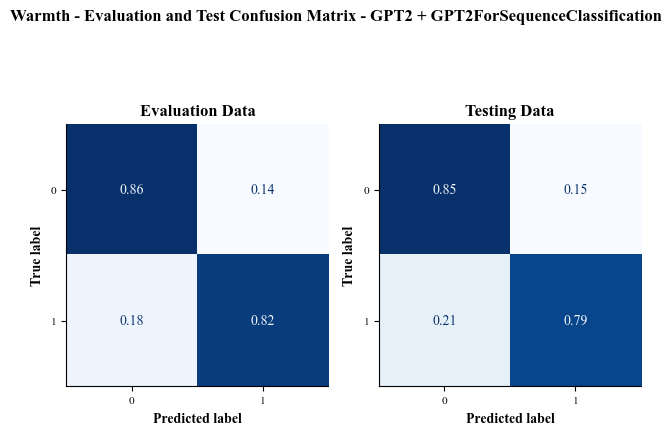

~~~~~~~~~~~~~~~~~~~~
Fitting best params to estimator


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


--------------------
Preprocessing y_pred logits and labels for Warmth:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32


  0%|          | 0/75 [00:00<?, ?it/s]

--------------------
Preprocessing y_pred logits and labels for Warmth:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing y_pred logits and labels for Warmth:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing y_pred logits and labels for Warmth:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing

 17%|█▋        | 1/6 [01:56<09:44, 116.94s/it]

~~~~~~~~~~~~~~~~~~~~
Done predicting!
~~~~~~~~~~~~~~~~~~~~
 Metrics:
~~~~~~~~~~~~~~~~~~~~
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       427
           1       0.67      0.79      0.72       166

    accuracy                           0.83       593
   macro avg       0.79      0.82      0.80       593
weighted avg       0.84      0.83      0.84       593

--------------------
Log Loss/Cross Entropy: 0.34
--------------------
Explained Variance: 0.23
--------------------
Accuracy: 0.84
--------------------
Balanced Accuracy: 0.83
--------------------
Precision: 0.69
--------------------
Average Precision: 0.83
--------------------
Recall: 0.81
--------------------
F1-score: 0.74
--------------------
Matthews Correlation Coefficient: 0.63
--------------------
Brier Score: 0.11
--------------------
Fowlkes–Mallows Index: 0.77
--------------------
R2 Score: 0.22
--------------------
ROC: 0.92
---------------

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading Estimator.


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Done loading Xy and estimator!
['eval_metrics_dict', 'test_metrics_dict', 'df_val_data', 'df_test_data', 'df_train_data']
--------------------
============================== EVALUATING DATASET OF LENGTH 5928 ON COMPETENCE ==============================
--------------------
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       319
           1       0.74      0.89      0.81       274

    accuracy                           0.80       593
   macro avg       0.81      0.81      0.80       593
weighted avg       0.82      0.80      0.80       593


~~~~~~~~~~~~~~~~~~~~
Examining predictions for Competence
Incorrectly Classified Reviews:
--------------------
TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: You will be able to build a long-term career in this Biotech organization, the core leadership team 
--------------------
--------------------
TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: Masters or equivalent

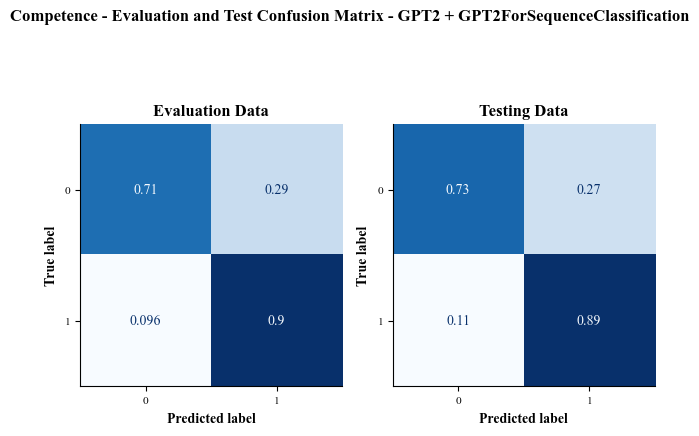

~~~~~~~~~~~~~~~~~~~~
Fitting best params to estimator


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


--------------------
Preprocessing y_pred logits and labels for Competence:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32


  0%|          | 0/75 [00:00<?, ?it/s]

--------------------
Preprocessing y_pred logits and labels for Competence:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing y_pred logits and labels for Competence:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing y_pred logits and labels for Competence:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
P

 33%|███▎      | 2/6 [03:46<07:29, 112.49s/it]

~~~~~~~~~~~~~~~~~~~~
Done predicting!
~~~~~~~~~~~~~~~~~~~~
 Metrics:
~~~~~~~~~~~~~~~~~~~~
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.73      0.80       319
           1       0.74      0.89      0.81       274

    accuracy                           0.80       593
   macro avg       0.81      0.81      0.80       593
weighted avg       0.82      0.80      0.80       593

--------------------
Log Loss/Cross Entropy: 0.44
--------------------
Explained Variance: 0.24
--------------------
Accuracy: 0.8
--------------------
Balanced Accuracy: 0.81
--------------------
Precision: 0.73
--------------------
Average Precision: 0.84
--------------------
Recall: 0.9
--------------------
F1-score: 0.81
--------------------
Matthews Correlation Coefficient: 0.62
--------------------
Brier Score: 0.14
--------------------
Fowlkes–Mallows Index: 0.68
--------------------
R2 Score: 0.2
--------------------
ROC: 0.89
------------------

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading df_test_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Transformers Results/Search+Xy/Transformers df_test_data - Warmth - OPENAIGPT + OpenAIGPTForSequenceClassification (Save_protocol=5).pkl
Loading df_val_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Transformers Results/Search+Xy/Transformers df_val_data - Warmth - OPENAIGPT + OpenAIGPTForSequenceClassification (Save_protocol=5).pkl
Loading test_metrics_dict from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Transformers Results/Search+Xy/Transformers test_metrics_dict - Warmth - OPENAIGPT + OpenAIGPTForSequenceClassification (Save_protocol=5).pkl
Loading Estimator.


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Done loading Xy and estimator!
['eval_metrics_dict', 'df_train_data', 'df_test_data', 'df_val_data', 'test_metrics_dict']
--------------------
============================== EVALUATING DATASET OF LENGTH 5928 ON WARMTH ==============================
--------------------
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       427
           1       0.74      0.68      0.71       166

    accuracy                           0.84       593
   macro avg       0.81      0.79      0.80       593
weighted avg       0.84      0.84      0.84       593


~~~~~~~~~~~~~~~~~~~~
Examining predictions for Warmth
Incorrectly Classified Reviews:
--------------------
TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: Spark new improvement opportunities for regional IT service managers
--------------------
--------------------
TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: We need you to help us realize this roadmap and spot opportun

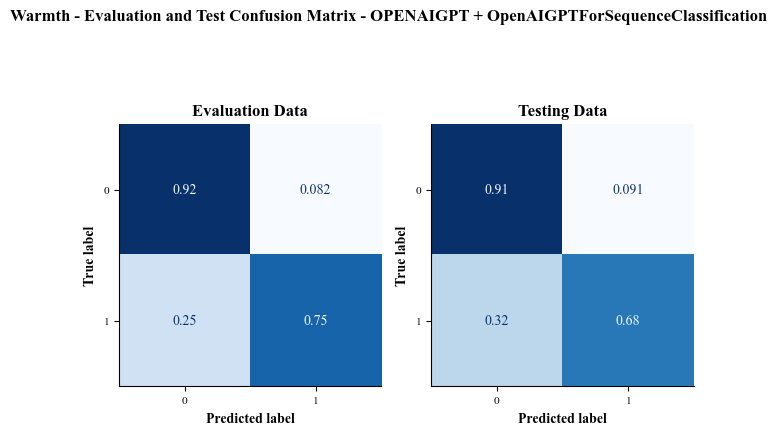

~~~~~~~~~~~~~~~~~~~~
Fitting best params to estimator


You're using a OpenAIGPTTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


--------------------
Preprocessing y_pred logits and labels for Warmth:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32


  0%|          | 0/75 [00:00<?, ?it/s]

--------------------
Preprocessing y_pred logits and labels for Warmth:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing y_pred logits and labels for Warmth:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing y_pred logits and labels for Warmth:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing

 50%|█████     | 3/6 [05:38<05:36, 112.20s/it]

~~~~~~~~~~~~~~~~~~~~
Done predicting!
~~~~~~~~~~~~~~~~~~~~
 Metrics:
~~~~~~~~~~~~~~~~~~~~
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89       427
           1       0.74      0.68      0.71       166

    accuracy                           0.84       593
   macro avg       0.81      0.79      0.80       593
weighted avg       0.84      0.84      0.84       593

--------------------
Log Loss/Cross Entropy: 0.38
--------------------
Explained Variance: 0.31
--------------------
Accuracy: 0.86
--------------------
Balanced Accuracy: 0.82
--------------------
Precision: 0.77
--------------------
Average Precision: 0.79
--------------------
Recall: 0.72
--------------------
F1-score: 0.75
--------------------
Matthews Correlation Coefficient: 0.65
--------------------
Brier Score: 0.11
--------------------
Fowlkes–Mallows Index: 0.8
--------------------
R2 Score: 0.31
--------------------
ROC: 0.91
----------------

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading Estimator.


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Done loading Xy and estimator!
['eval_metrics_dict', 'df_test_data', 'test_metrics_dict', 'df_val_data', 'df_train_data']
--------------------
============================== EVALUATING DATASET OF LENGTH 5928 ON WARMTH ==============================
--------------------
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90       427
           1       0.71      0.80      0.75       166

    accuracy                           0.85       593
   macro avg       0.81      0.84      0.82       593
weighted avg       0.86      0.85      0.86       593


~~~~~~~~~~~~~~~~~~~~
Examining predictions for Warmth
Incorrectly Classified Reviews:
--------------------
TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: You will be able to build a long-term career in this Biotech organization, the core leadership team 
--------------------
--------------------
TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: A strong interest in understa

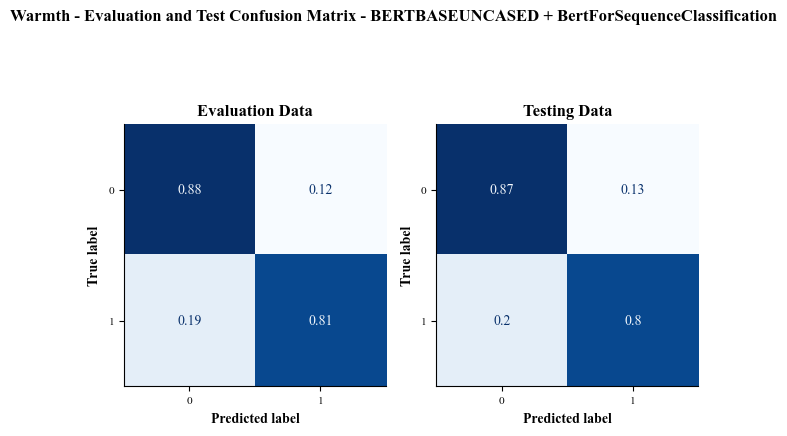

~~~~~~~~~~~~~~~~~~~~
Fitting best params to estimator


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


--------------------
Preprocessing y_pred logits and labels for Warmth:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32


  0%|          | 0/75 [00:00<?, ?it/s]

--------------------
Preprocessing y_pred logits and labels for Warmth:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing y_pred logits and labels for Warmth:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing y_pred logits and labels for Warmth:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing

 67%|██████▋   | 4/6 [07:05<03:24, 102.19s/it]

~~~~~~~~~~~~~~~~~~~~
Done predicting!
~~~~~~~~~~~~~~~~~~~~
 Metrics:
~~~~~~~~~~~~~~~~~~~~
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.90       427
           1       0.71      0.80      0.75       166

    accuracy                           0.85       593
   macro avg       0.81      0.84      0.82       593
weighted avg       0.86      0.85      0.86       593

--------------------
Log Loss/Cross Entropy: 0.34
--------------------
Explained Variance: 0.31
--------------------
Accuracy: 0.86
--------------------
Balanced Accuracy: 0.84
--------------------
Precision: 0.72
--------------------
Average Precision: 0.82
--------------------
Recall: 0.81
--------------------
F1-score: 0.76
--------------------
Matthews Correlation Coefficient: 0.66
--------------------
Brier Score: 0.11
--------------------
Fowlkes–Mallows Index: 0.79
--------------------
R2 Score: 0.3
--------------------
ROC: 0.92
----------------

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading Estimator.


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Done loading Xy and estimator!
['eval_metrics_dict', 'df_test_data', 'test_metrics_dict', 'df_val_data', 'df_train_data']
--------------------
============================== EVALUATING DATASET OF LENGTH 5928 ON COMPETENCE ==============================
--------------------
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       319
           1       0.81      0.85      0.83       274

    accuracy                           0.84       593
   macro avg       0.84      0.84      0.84       593
weighted avg       0.84      0.84      0.84       593


~~~~~~~~~~~~~~~~~~~~
Examining predictions for Competence
Incorrectly Classified Reviews:
--------------------
TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: Spark new improvement opportunities for regional IT service managers
--------------------
--------------------
TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: You will be able to build a long-term career in this 

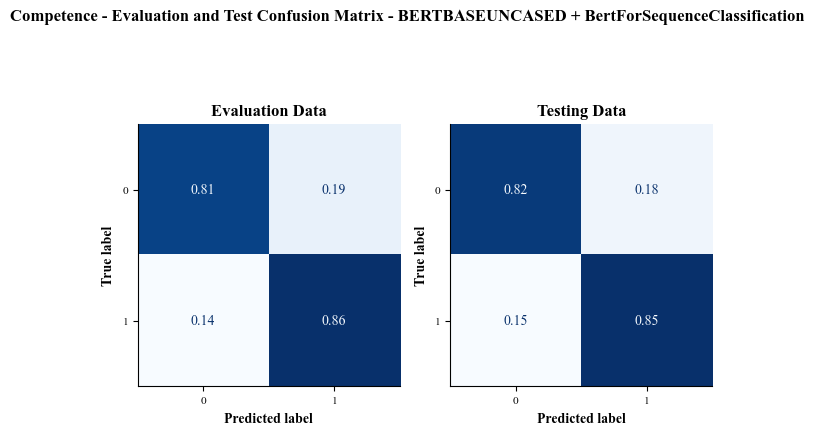

~~~~~~~~~~~~~~~~~~~~
Fitting best params to estimator


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


--------------------
Preprocessing y_pred logits and labels for Competence:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32


  0%|          | 0/75 [00:00<?, ?it/s]

--------------------
Preprocessing y_pred logits and labels for Competence:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing y_pred logits and labels for Competence:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing y_pred logits and labels for Competence:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
P

 83%|████████▎ | 5/6 [08:34<01:37, 97.63s/it] 

~~~~~~~~~~~~~~~~~~~~
Done predicting!
~~~~~~~~~~~~~~~~~~~~
 Metrics:
~~~~~~~~~~~~~~~~~~~~
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.85       319
           1       0.81      0.85      0.83       274

    accuracy                           0.84       593
   macro avg       0.84      0.84      0.84       593
weighted avg       0.84      0.84      0.84       593

--------------------
Log Loss/Cross Entropy: 0.39
--------------------
Explained Variance: 0.34
--------------------
Accuracy: 0.83
--------------------
Balanced Accuracy: 0.84
--------------------
Precision: 0.8
--------------------
Average Precision: 0.87
--------------------
Recall: 0.86
--------------------
F1-score: 0.83
--------------------
Matthews Correlation Coefficient: 0.67
--------------------
Brier Score: 0.12
--------------------
Fowlkes–Mallows Index: 0.72
--------------------
R2 Score: 0.33
--------------------
ROC: 0.9
-----------------

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading df_test_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Transformers Results/Search+Xy/Transformers df_test_data - Competence - OPENAIGPT + OpenAIGPTForSequenceClassification (Save_protocol=5).pkl
Loading Estimator.


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Done loading Xy and estimator!
['test_metrics_dict', 'eval_metrics_dict', 'df_val_data', 'df_train_data', 'df_test_data']
--------------------
============================== EVALUATING DATASET OF LENGTH 5928 ON COMPETENCE ==============================
--------------------
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       319
           1       0.73      0.92      0.81       274

    accuracy                           0.81       593
   macro avg       0.82      0.81      0.81       593
weighted avg       0.83      0.81      0.81       593


~~~~~~~~~~~~~~~~~~~~
Examining predictions for Competence
Incorrectly Classified Reviews:
--------------------
TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: Spark new improvement opportunities for regional IT service managers
--------------------
--------------------
TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: You will be able to build a long-term career in this 

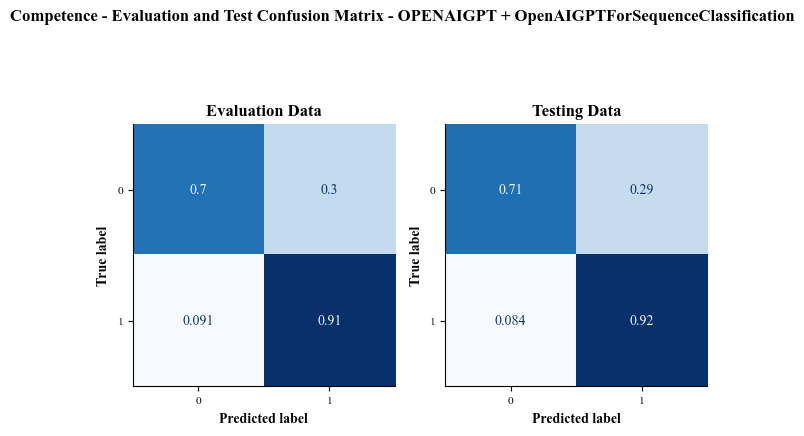

~~~~~~~~~~~~~~~~~~~~
Fitting best params to estimator


You're using a OpenAIGPTTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


--------------------
Preprocessing y_pred logits and labels for Competence:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32


  0%|          | 0/75 [00:00<?, ?it/s]

--------------------
Preprocessing y_pred logits and labels for Competence:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing y_pred logits and labels for Competence:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
Preprocessing y_pred logits and labels for Competence:
--------------------
y_pred_logits shape: torch.Size([20, 2]), torch.float32
--------------------
--------------------
Getting y_pred_prob through softmax of y_pred_logits.
Using torch.nn.functional.softmax.
y_pred_prob_array shape: (20, 2), float32
--------------------
P

100%|██████████| 6/6 [10:27<00:00, 104.55s/it]

~~~~~~~~~~~~~~~~~~~~
Done predicting!
~~~~~~~~~~~~~~~~~~~~
 Metrics:
~~~~~~~~~~~~~~~~~~~~
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80       319
           1       0.73      0.92      0.81       274

    accuracy                           0.81       593
   macro avg       0.82      0.81      0.81       593
weighted avg       0.83      0.81      0.81       593

--------------------
Log Loss/Cross Entropy: 0.48
--------------------
Explained Variance: 0.25
--------------------
Accuracy: 0.8
--------------------
Balanced Accuracy: 0.81
--------------------
Precision: 0.72
--------------------
Average Precision: 0.85
--------------------
Recall: 0.91
--------------------
F1-score: 0.81
--------------------
Matthews Correlation Coefficient: 0.62
--------------------
Brier Score: 0.15
--------------------
Fowlkes–Mallows Index: 0.68
--------------------
R2 Score: 0.19
--------------------
ROC: 0.89
----------------

In [33]:
%%time
print('#'*40)
print('Starting!')
print('#'*40)

analysis_columns = ['Warmth', 'Competence']
text_col = 'Job Description spacy_sentencized'

# Get existing estimators
estimator_names_list = get_existing_files()
done_estimators = glob.glob(f'{done_xy_save_path}*')
done_files = [
    'df_train_data', 'df_test_data', 'df_val_data', 'eval_metrics_dict', 'test_metrics_dict'
]

# Identify cols, vectorizers and classifiers
for estimators_file in tqdm.tqdm(glob.glob(f'{results_save_path}{method} Estimator - *.model')):
    assert f'{method} Estimator - ' in estimators_file, f'Estimators file name {estimators_file} does not contain {method} Estimator - '
    col = estimators_file.split(f'{method} Estimator - ')[-1].split(' - ')[0]
    vectorizer_name = estimators_file.split(f'{col} - ')[-1].split(' + ')[0]
    classifier_name = estimators_file.split(f'{vectorizer_name} + ')[-1].split(' (Save_protocol=')[0]

    if classifier_name in transformers_pipe.keys():
        model = transformers_pipe[classifier_name]['model']
        tokenizer = transformers_pipe[classifier_name]['tokenizer']
        config = transformers_pipe[classifier_name]['config']
        protocol = int(estimators_file.split(f'{vectorizer_name} + ')[-1].split(' (Save_protocol=')[-1].split(').model')[0])
        with open(f'{done_xy_save_path}{method} training_args_dict - {col} - {vectorizer_name} + {classifier_name}.json', 'r') as f:
            training_args_dict = json.load(f)
        output_dir = training_args_dict['output_dir'] = estimators_file

        # Load Table DF
        df_metrics = make_df_metrics(
            vectorizers_pipe=vectorizers_pipe, classifiers_pipe=classifiers_pipe, transformers_pipe=transformers_pipe,
            metrics_list=metrics_dict,
            col=col, vectorizer_name=vectorizer_name, classifier_name=classifier_name, protocol=protocol
        )
        print('~'*20)
        print(f'Loading data for {col} - {vectorizer_name} + {classifier_name}')
        print('~'*20)
        # Load X, y and estimator
        (
            X_train, y_train, train_dataset,
            X_test, y_test, test_dataset, y_test_pred, y_test_pred_prob,
            X_val, y_val, val_dataset, y_val_pred, y_val_pred_prob,
            train_class_weights, train_class_weights_ratio, train_class_weights_dict,
            test_class_weights_dict, test_class_weights_ratio, test_class_weights_dict,
            saved_estimator, tokenizer, config, eval_metrics_dict, test_metrics_dict,
        ) = load_Xy_estimator(
            model, tokenizer, config,
            col, vectorizer_name, classifier_name, protocol,
        )

        if hasattr(saved_estimator, 'to'):
            saved_estimator = saved_estimator.to(device)

        print('-'*20)
        print(f'{"="*30} EVALUATING DATASET OF LENGTH {len(X_train)+len(X_test)+len(X_val)} ON {col.upper()} {"="*30}')
        print('-'*20)
        print(
            f'Testing Classification Report:\n{(train_report:=metrics.classification_report(y_test, y_test_pred, labels=np.unique(y_test_pred), zero_division=0))}\n'
        )
        # Examine predictions
        examine_predictions(
            X_test, y_test, y_test_pred, col
        )
        print('='*20)
        # Train and Test Confusion Matrix
        print('='*20)
        print('Evaluation and Test Confusion Matrix:\n')
        close_plots()
        fig, axs = plt.subplots(1, 2)
        fig.suptitle(f'{col} - Evaluation and Test Confusion Matrix - {vectorizer_name} + {classifier_name}')
        for ax in axs:
            ax.set_aspect('equal')
        val_cm = metrics.ConfusionMatrixDisplay.from_predictions(
            y_val, y_val_pred, normalize='true', ax=axs[0], cmap=plt.cm.Blues, colorbar=False
        )
        val_cm.ax_.set_title('Evaluation Data')
        test_cm = metrics.ConfusionMatrixDisplay.from_predictions(
            y_test, y_test_pred, normalize='true', ax=axs[1], cmap=plt.cm.Blues, colorbar=False
        )
        test_cm.ax_.set_title('Testing Data')
        plt.tight_layout()
        for image_save_format in ['eps', 'png', 'svg']:
            save_path = f'{plot_save_path}{method} {col} - Evaluation and Test Confusion Matrix - {vectorizer_name} + {classifier_name}.{image_save_format}'
            try:
                print(f'Evaluation and Test Confusion Matrix plot at {save_path}')
                fig.savefig(
                    save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
                )
            except:
                pass
        show_and_close_plots()
        print('='*20)

        # Fit estimator
        print('~'*20)
        print('Fitting best params to estimator')
        X = np.concatenate((X_test, X_val), axis=0)
        y = np.concatenate((y_test, y_val), axis=0)
        X_encodings = tokenizer(
            X.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors=returned_tensor
        ).to(device)
        dataset = ToDataset(X_encodings, y)

        # Accelerate model
        (
            saved_estimator, tokenizer, dataset
        ) = accelerator.prepare(
            saved_estimator, tokenizer, dataset
        )
        # saved_estimator.eval()

        # Initalize trainer
        estimator = ImbTrainer(
            model=saved_estimator,
            tokenizer=tokenizer,
            args=TrainingArguments(**training_args_dict),
            preprocess_logits_for_metrics=preprocess_logits_for_metrics_y_pred_prob,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)], # [TensorBoardCallback()]
            data_collator=transformers.DataCollatorWithPadding(tokenizer),
        )

        # Get prediction results
        if estimator.place_model_on_device:
            estimator.model.to(device)
        y_pred_logits, y_labels, metrics_dict = estimator.predict(dataset)
        y_pred = metrics_dict.pop('test_y_pred')
        y_pred_prob = metrics_dict.pop('test_y_pred_prob')
        metrics_dict = clean_metrics_dict(metrics_dict, list(metrics_dict.keys())[0].split('_')[0])
        save_fitted_estimator(estimator, metrics_dict, col, vectorizer_name, classifier_name, protocol)
        print('Done predicting!')

        # Evaluate Model
        df_metrics = evaluation(
            y_labels, y_pred,
            metrics_dict, df_metrics,
            col, vectorizer_name, classifier_name, plot_enabled=False,
        )

        # Confirmatory Regression
        prob_confirmatory_tests(y_pred, y_pred_prob)

        # Save Vectorizer, Selector, and Classifier
        save_table(df_metrics, col, vectorizer_name, classifier_name, protocol)
